In [1]:
import argparse
import numpy as np
import pandas as pd
import os, sys
import neuroglancer
import matplotlib
from matplotlib import pyplot as plt

In [2]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer
neuroglancer.set_server_bind_address(bind_port='33645')

Connecting dklab@192.168.1.12:3306


In [3]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes'
#contourpath = os.path.join(DIR, 'MD589', 'full_brain_volume_annotated.npy')
#contourpath = os.path.join(DIR, 'MD589', 'MD589_full_filled.npy')
contourpath = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes/atlasV8/volume_test.npy'
structure = 'SC'
#contourpath = os.path.join(DIR, 'atlasV7', 'score_volumes', 'Sp5O_R.npy')
#contourpath = os.path.join(DIR, 'atlasV7', '10.0um_annotationAsScoreVolume', '{}.npy'.format(structure))
contour = np.load(contourpath)

In [ ]:
contour.dtype, contour.shape, np.median(contour), np.mean(contour), np.amax(contour)

In [ ]:
plt.hist(contour.flatten(), bins=100)
plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
colors = {'Sp5O_R':23, 'SC':18, 'IC':11, 'Sp5C_R':21}
color = colors[structure]

In [ ]:
volume = contour.copy()
threshold = 0.90
volume_nonzero_indices = volume >= threshold
volume_nonone_indices = volume < threshold
volume[volume_nonzero_indices] = color
volume[volume_nonone_indices] = 0
vm = volume.astype(np.uint8)
vm.shape, vm.dtype, vm.ndim

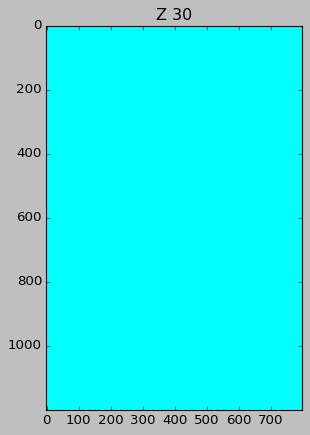

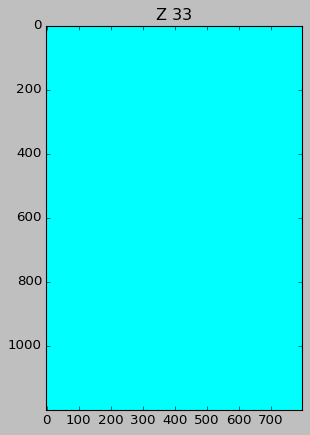

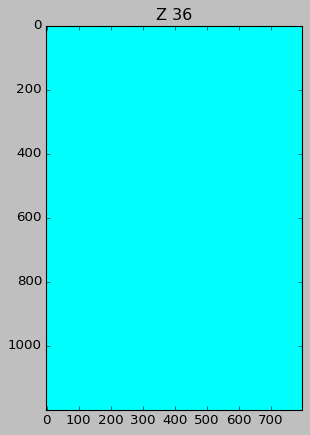

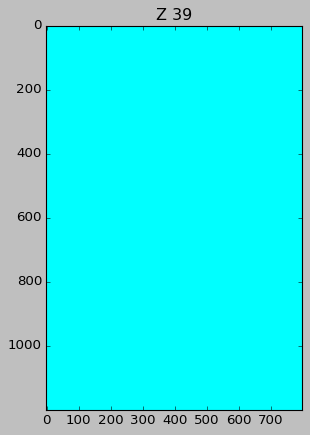

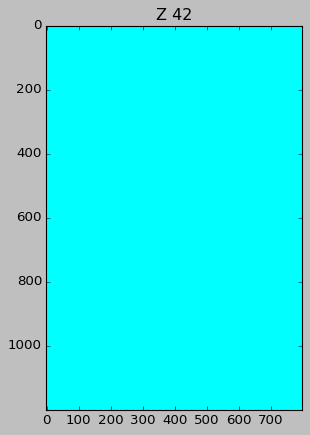

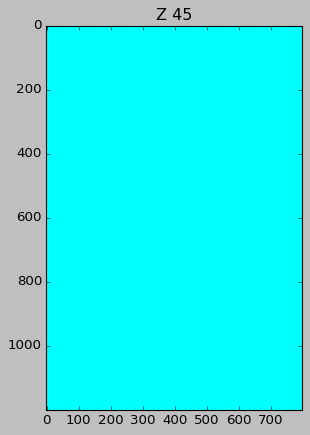

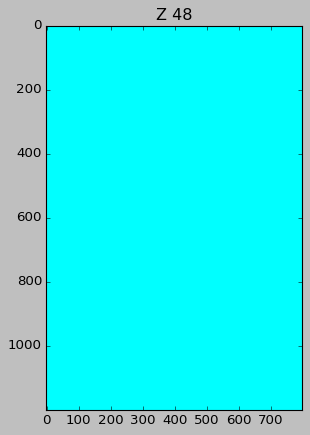

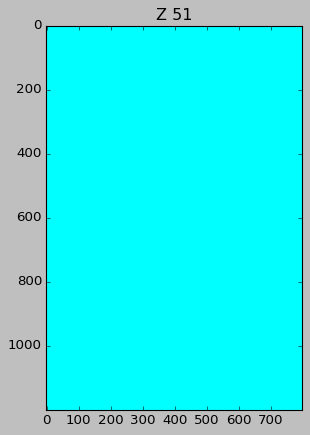

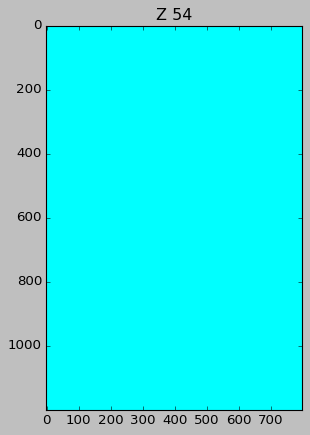

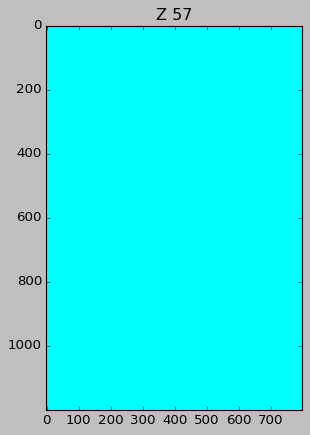

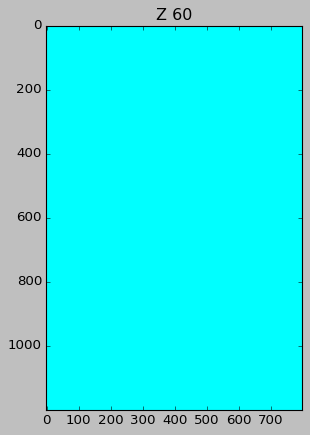

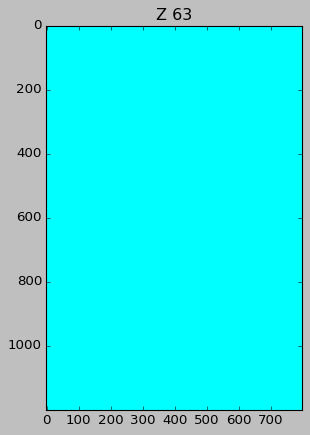

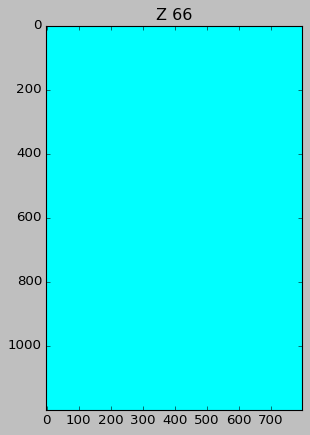

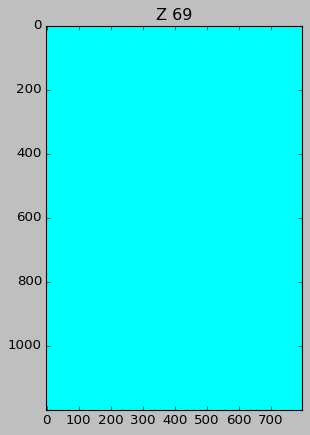

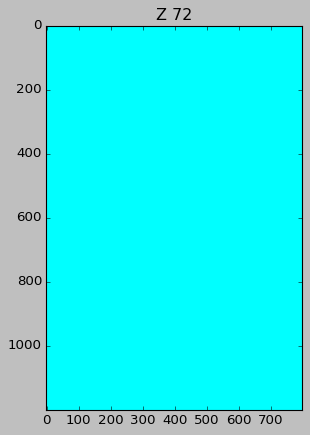

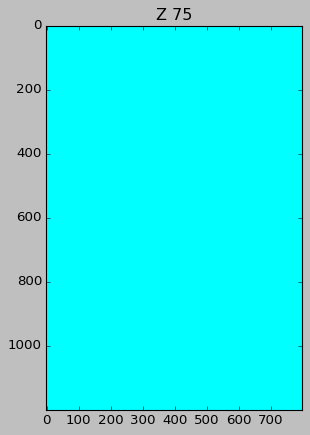

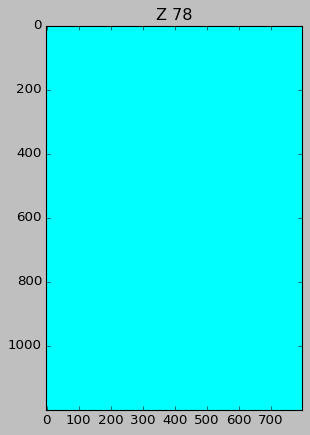

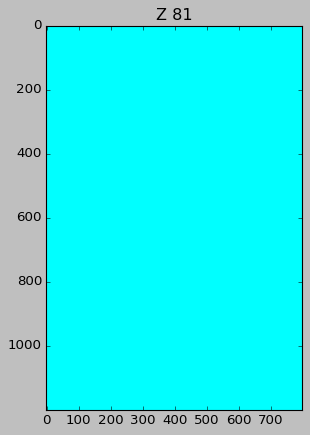

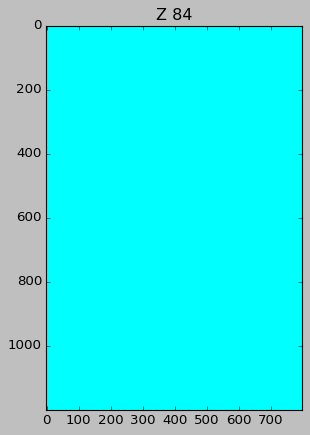

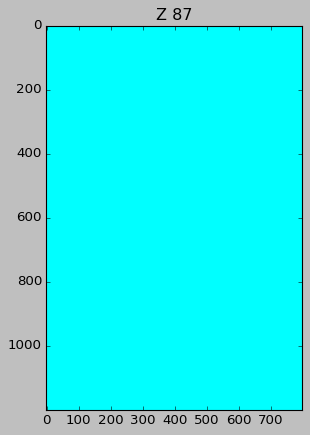

In [4]:
arr = np.swapaxes(contour,0,2)
limit = 10
start = (arr.shape[2] // 2) - limit
end = start + limit * 2
nrows = end - start
ncols = 1
plt.style.use('classic')
for i in range(30, 90, 3):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i], cmap='cool', interpolation='none')
    #plt.imshow(mat, cmap='tab20', interpolation='none')
    plt.show()

In [5]:
vm = contour.copy()

In [6]:
zdim = vm.shape[2]
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='um',
    scales=[10,10,20])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layout = '4panel'
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=vm,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = float(toRaw(getDataValue()));
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")

print(viewer)

http://127.0.0.1:33645/v/301168948b39305251741b3ccec1039cc63538ce/


In [ ]:
#neuroglancer.stop()